**Garbage Classifier Using PyTorch**

In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

Classes of garbage:

In [2]:
data_dir  = './Data/Plastic Classification'

classes = os.listdir(data_dir)
print(classes)

['HDPE', 'LDPE', 'Other', 'PET', 'PP', 'PS', 'PVC']


## Transformations:

Now, let's apply transformations to the dataset and import it for use.

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(data_dir, transform = transformations)

Let's create a helper function to see the image and its corresponding label:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: HDPE (Class No: 0)


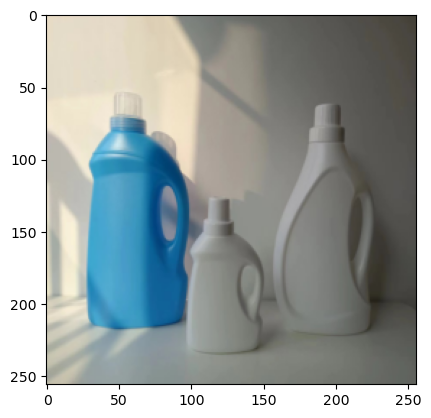

In [5]:
img, label = dataset[13]
show_sample(img, label)

# Loading and Splitting Data:

In [6]:
random_seed = 11
torch.manual_seed(random_seed)

We'll split the dataset into training, validation and test sets:

In [7]:
datasetLen = len(dataset)
train_size = int(datasetLen * 0.7)
val_size = int(datasetLen * 0.1)
test_size = datasetLen - train_size - val_size  # Ensure the total matches the dataset length
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(1339, 191, 383)

In [8]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

Now, we'll create training and validation dataloaders using `DataLoader`.

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

This is a helper function to visualize batches:

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

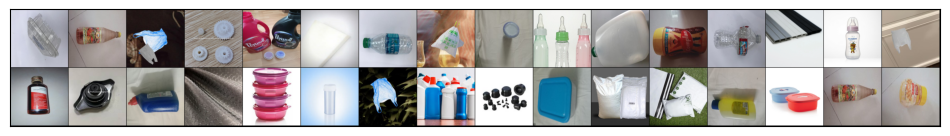

In [11]:
show_batch(train_dl)

# Model Base:

Let's create the model base:

In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

We'll be using ResNet50 for classifying images:

In [13]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

c:\Users\fnovi\miniconda3\envs\dev\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\fnovi\miniconda3\envs\dev\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\fnovi/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


## Porting to GPU:

GPUs tend to perform faster calculations than CPU. Let's take this advantage and use GPU for computation:

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

# Training the Model:

This is the function for fitting the model.

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
model = to_device(ResNet(), device)

In [19]:
evaluate(model, val_dl)

{'val_loss': 1.9647163152694702, 'val_acc': 0.11516203731298447}

Let's start training the model:

In [20]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.7053, val_loss: 1.4867, val_acc: 0.7487
Epoch 2: train_loss: 1.4008, val_loss: 1.3559, val_acc: 0.8587
Epoch 3: train_loss: 1.2637, val_loss: 1.2957, val_acc: 0.8952
Epoch 4: train_loss: 1.2092, val_loss: 1.2888, val_acc: 0.8954
Epoch 5: train_loss: 1.1910, val_loss: 1.2887, val_acc: 0.8902
Epoch 6: train_loss: 1.1866, val_loss: 1.2787, val_acc: 0.8954
Epoch 7: train_loss: 1.1796, val_loss: 1.2770, val_acc: 0.8902
Epoch 8: train_loss: 1.1772, val_loss: 1.2788, val_acc: 0.8850


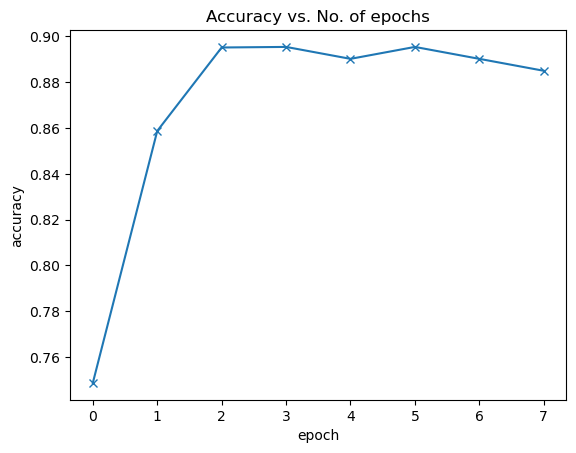

In [21]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

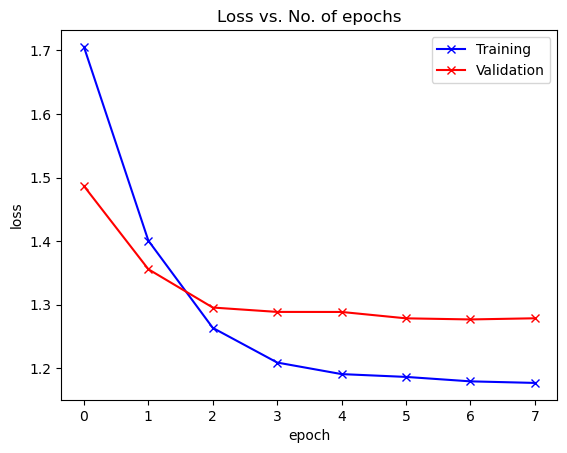

In [22]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

# Visualizing Predictions:

In [23]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Let us see the model's predictions on the test dataset:

Label: PET , Predicted: PET


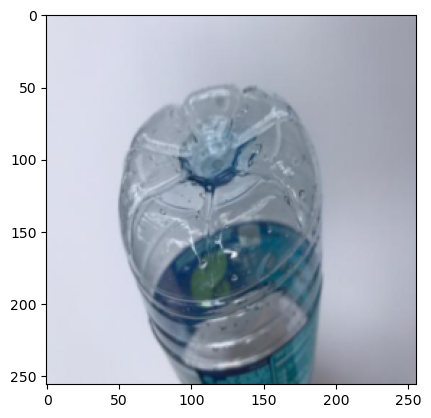

In [24]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: LDPE , Predicted: LDPE


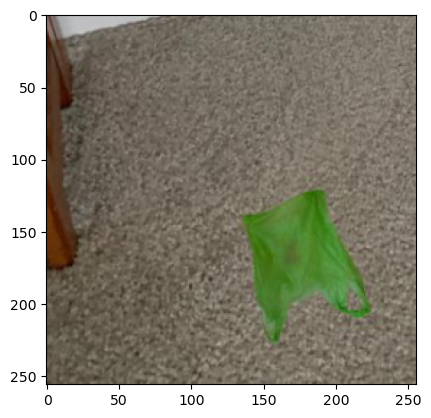

In [25]:
img, label = test_ds[350]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: PS , Predicted: PS


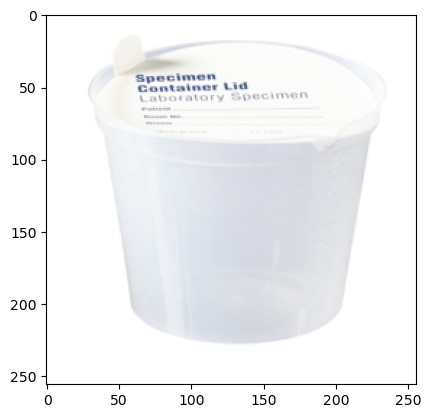

In [26]:
img, label = test_ds[21]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

# Predicting External Images:

Let's now test with external images.

I'll use `urllib` for downloading external images.

In [46]:
import urllib.request
urllib.request.urlretrieve("https://assets1.cbsnewsstatic.com/hub/i/r/2024/11/30/a010ebc7-4b89-4ef5-a91b-9ecbfc2c9207/thumbnail/640x360/09bc30cb1697b44acdad55a423b4d391/hey-ray-7.jpg?v=04a4ba26f526ed8207f014fe1018c4aa", "ExternalImages/PET Water Bottle.jpg")
urllib.request.urlretrieve("https://arnallgrocery.com/cdn/shop/products/istockphoto-172732045-612x612.jpg?v=1672417737", "ExternalImages/HDPE Milk Jug.jpg")    
urllib.request.urlretrieve("https://www.oatey.com/sites/default/files/2024-11/Do%20I%20Need%20to%20Chamfer%20PVC%20Pipe_BlogImage_450x360-02.jpg.png", "ExternalImages/PVC Pipe.jpg") 
urllib.request.urlretrieve("https://media.newyorker.com/photos/5e59705cdce85800084faae0/master/w_1600%2Cc_limit/200309_r35983b.jpg", "ExternalImages/LDPE Shopping Bag.jpg")
urllib.request.urlretrieve("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQdVB2-7ho_UYlQNjn7OjiO0XTTXaRRJgdZog&s", "ExternalImages/PP Tuperware.jpg")
urllib.request.urlretrieve("https://www.retlawindustries.com/Content/files/fork.png", "ExternalImages/PS Fork.jpg")
urllib.request.urlretrieve("https://www.chiccousa.com/on/demandware.static/-/Sites-chicco_catalog/default/dw39f8a5f8/images/products/feeding/duo-bottle/chicco-duo-bottle-5oz-single.jpg?sw=280&sh=280&sm=fit", "ExternalImages/Other Baby Bottle.jpg")

('ExternalImages/Other Baby Bottle.jpg',
 <http.client.HTTPMessage at 0x28704d58390>)

Let us load the model. You can load an external pre-trained model too!

In [43]:
loaded_model = model

This function takes the image's name and prints the predictions:

In [44]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("The image resembles", predict_image(example_image, loaded_model) + ".")

The image resembles PET.


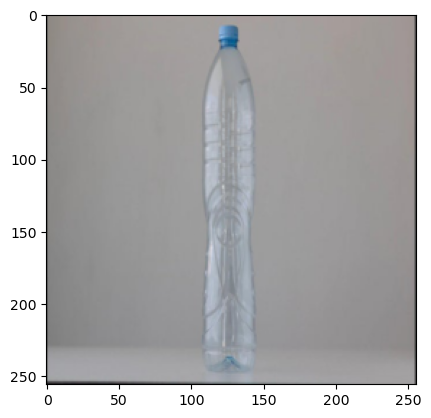

In [34]:
predict_external_image('ExternalImages/PET Water Bottle.jpg')

The image resembles HDPE.


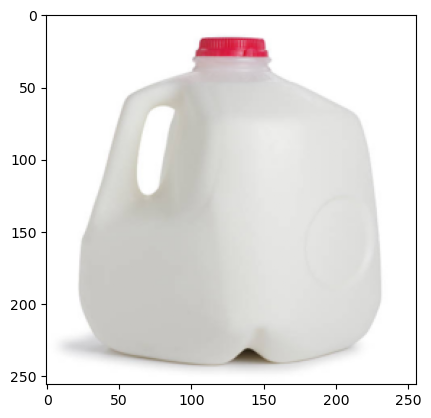

In [35]:
predict_external_image('ExternalImages/HDPE Milk Jug.jpg')

The image resembles PVC.


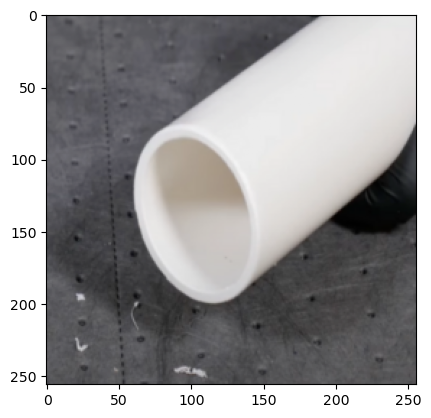

In [36]:
predict_external_image('ExternalImages/PVC Pipe.jpg')

The image resembles PET.


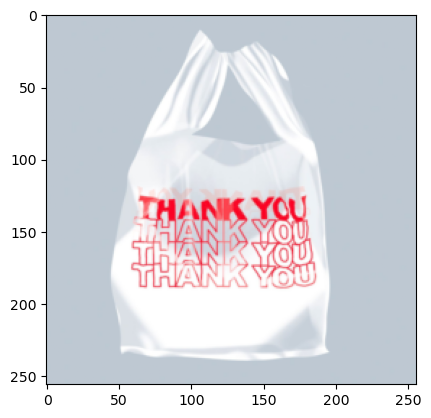

In [37]:
predict_external_image('ExternalImages/LDPE Shopping Bag.jpg')

The image resembles PP.


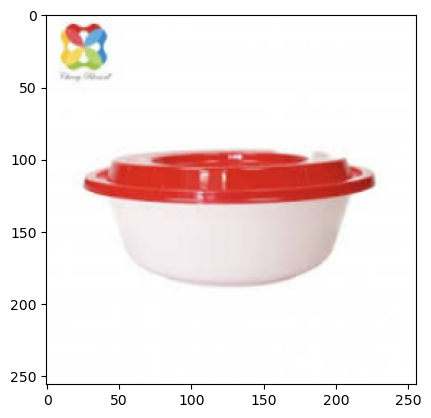

In [47]:
predict_external_image('ExternalImages/PP Tuperware.jpg')

The image resembles PS.


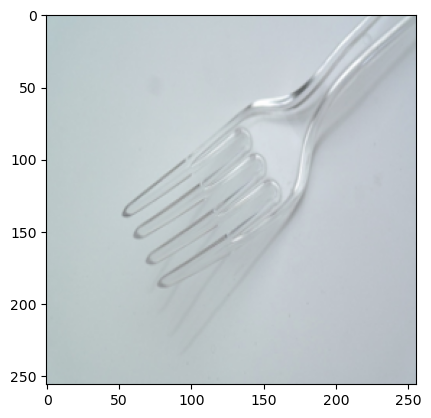

In [39]:
predict_external_image('ExternalImages/PS Fork.jpg')

The image resembles Other.


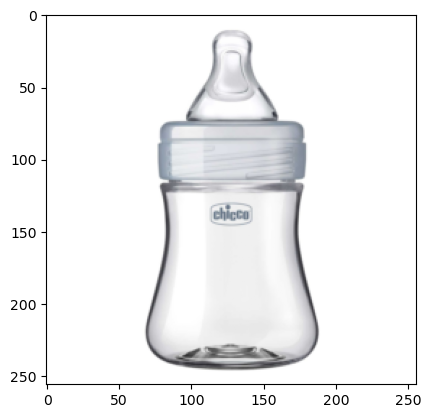

In [40]:
predict_external_image('ExternalImages/Other Baby Bottle.jpg')

In [41]:
torch.save(model.state_dict(), 'plastic_classifier.pth')